# Thesis Code
### Zachary Nathan, May 28 2023

### Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ee
import utm
import time
import math
import torch
import gpytorch

import numpy as np
import pandas as pd
import gstools as gs
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable
from sklearn import metrics
from functools import reduce
from itertools import combinations

from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP, ApproximateGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(999)

## API code

### PredictiveSampler class with GPs

In [4]:
class PredictiveSampler:
    
    def __init__(
        self,
        measurements: pd.DataFrame = None,
        grid_size: int = 400,
        extrapolate_factor: float = 0.0
    ) -> None:
        
        self.measurements: pd.DataFrame = measurements
        self.grid_size: int = grid_size
        self.extrapolate_factor: float = extrapolate_factor

        self.grid: pd.DataFrame = None
        self.x_min: float = -200.0
        self.x_max: float = 200.0
        self.y_min: float = -200.0
        self.y_max: float = 200.0
        self.xs: np.array = None
        self.ys: np.array = None
        
        self.generated_fields: List[str] = []
        self.predicted_fields: List[str] = []
        self.predicted_fields_var: List[str] = []

        self.cached_inducing_points: torch.tensor = None
        self.last_n_inducing_points: int = None
        
        self.init_grid()
        
    
    # create the 'grid' dataframe of x/y grid coordinate pairs, over the area covered by `points`
    def init_grid(self) -> None:
        
        # derive grid limits from `measurements`
        if self.measurements is not None:
            
            # find the bounds of `measurements`
            self.x_max, self.y_max = self.measurements[['x_pos', 'y_pos']].max().tolist()
            self.x_min, self.y_min = self.measurements[['x_pos', 'y_pos']].min().tolist()

            # extrapolate the grid beyond the bounds of `measurements` by `extrapolate_factor`,
            # where 0.0 leaves the bounds unchanged, or 0.5 adds 50%
            if self.extrapolate_factor != 0.0:
                x_mid = (self.x_max + self.x_min) / 2
                y_mid = (self.y_max + self.y_min) / 2
                self.x_max += (self.x_max - self.x_mid) * self.extrapolate_factor
                self.x_min += (self.x_min - self.x_mid) * self.extrapolate_factor
                self.y_max += (self.y_max - self.y_mid) * self.extrapolate_factor
                self.y_min += (self.y_min - self.y_mid) * self.extrapolate_factor

        # generate the coordinates with `grid_size` rows and `grid_size` columns
        self.xs = np.linspace(self.x_min, self.x_max, self.grid_size)
        self.ys = np.linspace(self.y_min, self.y_max, self.grid_size)
        mesh_xs, mesh_ys = np.meshgrid(self.xs, self.ys)
        coords = np.array([mesh_xs.flatten(), mesh_ys.flatten()]).T
        
        self.grid = pd.DataFrame(coords, columns=['x_pos', 'y_pos']).astype(np.float32)
        
    
    # helper function to calculate the grid's diagonal size
    def grid_diagonal(self) -> float:
        
        return np.sqrt(np.square(self.x_max - self.x_min) + np.square(self.y_max - self.y_min))
    
    
    # helper function to return all `measurements` field names
    def measurements_fields(self) -> List[str]:
        
        return [
            column for column in self.measurements.columns
            if column not in ('x_pos', 'y_pos', 'latitude', 'longitude')
        ]
    
    
    # create a scatter plot of measurements data for each field/column
    def plot_measurements(
        self, 
        fields: List[str] = None,
        point_size: float = None,
        marker: str = 'o'
    ) -> None:
        
        if fields is None:
            fields = self.measurements_fields()
    
        for field in fields:
            if self.measurements is not None and field in self.measurements.columns:

                ax = sns.scatterplot(
                    self.measurements,
                    x='x_pos',
                    y='y_pos',
                    s=point_size,
                    hue=field,
                    edgecolor=None,
                    palette='rocket',
                    marker=marker
                )

                ax.set_title(f'Sensor measurements in field: {field}')
                ax.set_xlabel('x position (meters)')
                ax.set_ylabel('y position (meters)')
                ax.set_box_aspect(1)
                sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
                plt.show()
    
    
    # generate spatial random fields using gstools and store them in the `grid` dataframe
    def generate_random_fields(
        self,
        n_fields: int = 1,
        name: str = 'random_field',
        len_scale: float = 1.0,
        common_basis_factor: float = 0.0,
        minmax: bool = False,
        heatmaps: bool = False
    ) -> None:
        
        # use a Matern covariance model, same as GPyTorch
        covar = gs.Matern(
            nu=1.5,
            dim=2,
            var=1.0,
            len_scale=len_scale * (self.grid_diagonal() / 5)
        )
        srf = gs.SRF(covar)
        srf.set_pos([self.xs, self.ys], 'structured')

        if common_basis_factor > 0.0:
            basis_field = srf(seed=np.random.randint(0, 2**30)).flatten()
            assert common_basis_factor <= 1.0
        
        # generate fields and add them to `grid`
        for i in range(n_fields):

            column_name = f'{name}_{i}' if n_fields > 1 else name
            field = srf(seed=np.random.randint(0, 2**30)).flatten()

            if common_basis_factor > 0.0:
                field = (field * (1.0 - common_basis_factor)) + (basis_field * common_basis_factor)

            if minmax:
                field = (field - field.min()) / (field.max() - field.min())
            
            self.grid[column_name] = field.astype(np.float32)
            self.generated_fields.append(column_name)

            if heatmaps:
                self.heatmap_field(column_name)
                
    
    # plot a heatmap of a field in `grid`
    def heatmap_field(
        self,
        column: str,
        override_data = None,
        n_ticks: int = 9,
        log: bool = False,
        points: pd.DataFrame = None,
        diff_column: str = None,
        title: str = None
    ) -> None:
        
        data = override_data if override_data is not None else self.grid

        # if plotting the difference between two columns, create a temporary column
        if diff_column:
            name = 'temporary_column'
            data[name] = np.abs(data[column] - data[diff_column])
            column = name

        # pivot the list of x/y coordinates into a matrix with columns for x and rows for y
        data = data.pivot(index='y_pos', columns='x_pos', values=column)

        # log transformation, if plotting the log as is typical for variance
        if log:
            data = np.log(data)

        if diff_column:
            self.grid.drop(name, axis=1, inplace=True)

        ax = sns.heatmap(
            data,
            vmin=data.to_numpy().flatten().min(),
            vmax=data.to_numpy().flatten().max()
        )
        ax.invert_yaxis()

        ax.set_xlabel('x position (meters)')
        ax.set_xticks(np.floor(np.linspace(0, len(self.xs) - 1, n_ticks)))
        ax.set_xticklabels(np.linspace(self.x_min, self.x_max, n_ticks, dtype=int), rotation=45)

        ax.set_ylabel('y position (meters)')
        ax.set_yticks(np.floor(np.linspace(1, len(self.ys), n_ticks)))
        ax.set_yticklabels(np.linspace(self.y_min, self.y_max, n_ticks, dtype=int))

        if title is None:
            title = 'GP field prediction: ' + column + (' (log variance)' if log else '')
        plt.title(title, y=1.02)

        # scatter points over the heatmap, coordinates must first be converted into heatmap units
        if points is not None:
            plt.scatter(
                (points.x_pos - self.x_min) * self.grid_size / (self.x_max - self.x_min),
                (points.y_pos - self.y_min) * self.grid_size / (self.y_max - self.y_min)
            )
            
        plt.show()


    def drop_field(self, field_name: str) -> None:

        if field_name in self.grid.columns:
            self.grid.drop(field_name, axis=1, inplace=True)
        
        
    def fields_root_mean_squared_error(self, field_1: str, field_2: str) -> float:
        
        if field_1 not in self.grid.columns or field_2 not in self.grid.columns:
            raise ValueError(f'fields \'{field_1}\' and \'{field_2}\' not found')
            
        return np.sqrt(metrics.mean_squared_error(self.grid[field_1], self.grid[field_2]))
    
    def fields_mean_absolute_error(self, field_1: str, field_2: str) -> float:
        
        if field_1 not in self.grid.columns or field_2 not in self.grid.columns:
            raise ValueError(f'fields \'{field_1}\' and \'{field_2}\' not found')
            
        return metrics.mean_absolute_error(self.grid[field_1], self.grid[field_2])
        

    def noisify_series(
        self,
        data: pd.Series,  # input data to noisify
        noise_ratio: float,  # standard devation multiple for Gaussian noise; 0.1 -> 10% of deviation is noise
        stat_source: str = None  # source column (in self.grid) for calculating basis deviation
    ) -> pd.Series:
        
        stat_source = stat_source if stat_source is not None else data.name
        noise_sd = noise_ratio * self.grid[stat_source].std()
        noise = np.random.normal(0, noise_sd, data.size)
        return data + noise
    

    def simulate_lattice_samples(
        self,
        field_name: str,
        result_name: str = None,
        n_samples: int = 36,
        sample_noise_ratio: float = 0.01,  # standard devation multiple for Gaussian noise; 0.1 -> 10% of deviation is noise
        spatial_noise_ratio: float = 0.01,  # noise ratio for 'x_pos' and 'y_pos' as opposed to the simulated measurements
        pad_edges: bool = True,
        all_columns: bool = False,
        heatmap: bool = False
    ) -> pd.DataFrame:

        # number of rows for the lattice
        height = int(np.round(np.sqrt(n_samples)))
        remainder = n_samples - height ** 2

        # number of samples per row
        if remainder >= 0:
            row_counts = [height for _ in range(height)]
        else:
            row_counts = [height - 1 for _ in range(height)]
            remainder += height
        
        # remainder are evenly distributed among the middle rows if positive
        i = int((height - remainder) / 2)
        while remainder > 0:
            row_counts[i] += 1
            remainder -= 1
            i += 1

        # row numbers in the grid corresponding to the lattice
        row_size = len(self.xs)
        row_indices = np.linspace(0, len(self.ys) - 1, num=height).astype(int) \
            if not pad_edges else \
            np.linspace(0, len(self.ys) - 1, num=height * 2 + 1).astype(int)[1:-1:2]

        # grid indices using the row numbers and number of samples per row
        sample_indices = [
            y * row_size + x
            for i, y in enumerate(row_indices)
            for x in (
                np.linspace(0, row_size - 1, num=row_counts[i]).astype(int) \
                if not pad_edges else \
                np.linspace(0, row_size - 1, num=row_counts[i] * 2 + 1).astype(int)[1:-1:2]
            )
        ]

        # extract samples from the grid
        samples = self.grid.iloc[sample_indices].copy()

        # add noise by multiplying sample values by a 1-mean Gaussian with sd=noise_rato
        column_name = result_name if result_name is not None else f'{field_name}_sampled_{sample_noise_ratio}'
        
        samples[column_name] = self.noisify_series(
            samples[field_name],
            noise_ratio=sample_noise_ratio
        ).astype(np.float32)

        samples[['x_pos', 'y_pos']] = samples[['x_pos', 'y_pos']].apply(
            self.noisify_series,
            noise_ratio=spatial_noise_ratio
        ).astype(np.float32)

        if heatmap:
            self.heatmap_field(field_name, points=samples)

        if not all_columns:
            samples = samples[['x_pos', 'y_pos', column_name]]

        return samples.reset_index(drop=True)


    def simulate_lawnmower_sensors(
        self,
        field_names: List[str] = None,
        n_turns: int = 9,
        spacing: int = 5,  # 1 means every point along with the path, 2 means every second, etc.
        sensor_noise_ratio: float = 0.01,  # standard devation multiple for Gaussian noise; 0.1 -> 10% of deviation is noise
        spatial_noise_ratio: float = 0.01  # noise ratio for 'x_pos' and 'y_pos' as opposed to the simulated measurements
    ) -> pd.DataFrame:
        
        # lawnmower pattern (n_turns = 2):
        #
        #  ***************
        #                *
        #  ***************
        #  *
        #  ***************
        #
        
        # row numbers in the grid corresponding to lawnmower rows
        row_size = len(self.xs)
        row_indices = np.linspace(0, len(self.ys) - 1, num=n_turns + 1).astype(int)

        # grid indices corresponding to the points along the lawnmower rows
        row_sample_indices = [[y * row_size + x for x in range(row_size)] for y in row_indices]

        # grid indices corresponding to the points along right turns, after even-numbered lawnmower rows
        right_turn_indices = [
            [(y + 1) * row_size - 1 for y in range(row_indices[i] + 1, row_indices[i + 1])]
            for i in range(0, n_turns, 2)
        ]

        # grid indices corresponding to the points along left turns, after odd-numbered lawnmower rows
        left_turn_indices = [
            [y * row_size for y in range(row_indices[i] + 1, row_indices[i + 1])]
            for i in range(1, n_turns, 2)
        ]

        # interleave rows (some reversed) and turns into a single list of indices
        lawnmower_indices = []
        for i, row in enumerate(row_sample_indices):
            if i % 2 == 0:
                lawnmower_indices += row
                if i < n_turns:
                    lawnmower_indices += right_turn_indices[int(i / 2)]
            elif i % 2 == 1:
                lawnmower_indices += reversed(row)
                if i < n_turns:
                    lawnmower_indices += left_turn_indices[int(i / 2)]

        # default to the randomly generated fields if names aren't specified
        field_names = field_names if field_names is not None else self.generated_fields

        # extract measurements from the grid
        measurements = self.grid.iloc[lawnmower_indices[::spacing]].copy()[['x_pos', 'y_pos', *field_names]]

        # add noise by multiplying sample values by a 1-mean Gaussian with sd=noise_rato
        measurements[field_names] = measurements[field_names].apply(
            self.noisify_series,
            noise_ratio=sensor_noise_ratio
        ).astype(np.float32)

        measurements[['x_pos', 'y_pos']] = measurements[['x_pos', 'y_pos']].apply(
            self.noisify_series,
            noise_ratio=spatial_noise_ratio
        ).astype(np.float32)

        return measurements.reset_index(drop=True)
    
        
    # select_points: Greedily select the optimal sampling points from a field, as measured by a fitness function
    #
    # grid: Pandas dataframe containing field predictions, as returned by `predict_field`
    # field_name: String column name of the field to be evaluated
    # fitness_function: Function of the form fitness(field, variance) that calculates fitness scores for the given field,
    #                   where minimum fitness is 0 and optimal points have the highest scores. See examples below.
    # distance_factor: Determines how close the selected points can get to one another. This parameter multiplies
    #                  the default factor, calculated according to the size of the field and `n_points`.
    # n_points: The number of points to be selected
    # heatmaps: Whether to print heatmaps of the fitness field after each point is selected.
    #           Helpful when changing the `distance_factor` or `fitness_function`.
    #
    # return: A pandas dataframe with columns (`x_pos`, `y_pos`), as accepted by `xy_to_latlon` and `heatmap_field`
    #
    def select_points(
        self,
        field_name: str,
        fitness_function: Callable[[pd.Series, pd.Series], pd.Series],
        distance_factor: float = 1.0,
        n_points: int = 12,
        override_variance: str = None,
        all_columns: bool = False,
        heatmaps: bool = False
    ) -> pd.DataFrame:

        # extract relevant columns from the grid dataset
        variance = False
        columns = ['x_pos', 'y_pos', field_name]

        variance_name = f'{field_name}_var' if override_variance is None else override_variance
        if variance_name in self.grid.columns:
            variance = True
            columns.append(variance_name)
        data = self.grid[columns].copy()

        # calculate fitness of all points according to the specified function
        data['fitness'] = fitness_function(data[field_name], data[variance_name] if variance else None)

        # the 'distance factor' determines the how close the selected points can get to one another;
        # penalties are applied within a radius proportional to the field's diagonal divided by the number of points
        distance_factor *= self.grid_diagonal() / n_points

        # use a multiindex for quick access to coordinates
        data = data.set_index(['x_pos', 'y_pos'])
        all_points = data.index.to_frame().to_numpy()

        points = []
        for i in range(n_points):
            
            # select the next best point
            next_point = data.fitness.idxmax()
            points.append(next_point)

            # calculate distances and apply a fitness penalty to nearby points
            data['distance'] = np.sqrt(
                np.square(np.subtract(
                    all_points,  # vectorized for speed
                    np.array(next_point)
                )).sum(axis=1)  # (x - x`)^2 + (y - y`)^2
            )
            data.fitness *= 1 - np.exp(-data.distance / distance_factor)

            if heatmaps:
                self.heatmap_field('fitness', override_data=data.reset_index())

        samples = self.grid[self.grid[['x_pos', 'y_pos']].apply(tuple, axis=1).isin(points)]
        if not all_columns:
            samples = samples[['x_pos', 'y_pos', field_name]]
        
        return samples
    
    
    # fitness function for selecting maxima, transforms the field into [0,1]
    @staticmethod
    def maxima_fitness(field: pd.Series, variance: pd.Series) -> pd.Series:

        return (field - field.min()) / (field.max() - field.min())


    # fitness function for selecting minima, the opposite of maxima_fitness
    @staticmethod
    def minima_fitness(field: pd.Series, variance: pd.Series) -> pd.Series:

        return 1 - PredictiveSampler.maxima_fitness(field, variance)


    # fitness function for selecting points with the least information (highest variance)
    # transforms the field variance into [0,1] using a logarithmic scale
    @staticmethod
    def variance_fitness(field: pd.Series, variance: pd.Series) -> pd.Series:

        if variance is None:
            raise ValueError('field variance is required for the variance_fitness function')

        return PredictiveSampler.maxima_fitness(np.log(variance), None)
    

    # fitness function for selecting points with the most information, the opposite of variance_fitness
    @staticmethod
    def inverse_variance_fitness(field: pd.Series, variance: pd.Series) -> pd.Series:

        return 1 - PredictiveSampler.maxima_fitness(np.log(variance), None)


    # this example selects low-variance maxima; many such combinations are possible
    @staticmethod
    def combined_fitness(field: pd.Series, variance: pd.Series) -> pd.Series:

        return (
            PredictiveSampler.maxima_fitness(field, variance) *
            PredictiveSampler.inverse_variance_fitness(field, variance)
        )
    
    
    # the fitness function can be a random field, for selecting random points that are separated
    def random_fitness(
        self,
        field: pd.Series,
        variance: pd.Series
    ) -> pd.Series:
        
        self.generate_random_fields(name='random_fitness', len_scale=0.2, minmax=True)
        return self.grid['random_fitness'].copy()
        
        
    #################### GPyTorch ############################################################
        
    # convert a tensor of values to a tensor of z-scores, per column
    @staticmethod
    def standardize_tensor(data: torch.tensor) -> torch.tensor:

        means = data.mean(dim=0, keepdim=True)
        stds = data.std(dim=0, keepdim=True)
        return (data - means) / stds, means, stds


    # invert the standardize_tensor function using returned z-scores, means, and stds
    @staticmethod
    def inverse_standardize_tensor(
        data: torch.tensor,
        means: torch.tensor,
        stds: torch.tensor
    ) -> torch.tensor:

        return data * stds + means


    # adaptive inducing points selection, see https://arxiv.org/pdf/2107.10066.pdf
    @staticmethod
    def select_inducing_points(
        samples: torch.tensor,
        kernel: gpytorch.kernels.Kernel,
        threshold: float = 0.5,
        max_points: int = None,
        no_print: bool = False
    ) -> torch.tensor:

        # start with the first sample as the only inducing point
        inducing_points = samples[0]
        n_points = 1

        # check for each additional sample to determine the best inducing points
        for sample in samples[1:]:
            sample_tensor = sample if n_points == 1 else sample.repeat(n_points, 1)

            # d = max(kernel(sample, inducing_point) for inducing_point in inducing_points)
            # that is, the maximum output of the kernel for the sample with any inducing point
            d = kernel(sample_tensor, inducing_points).diag().max().item()

            if d < threshold:
                # add the current sample to the set of inducing points
                if n_points == 1:
                    inducing_points = torch.stack([inducing_points, sample])
                else:
                    inducing_points = torch.cat([inducing_points, sample.repeat(1, 1)], 0)
                n_points += 1

                if max_points and n_points > max_points:
                    raise RuntimeError(f'maximum number of inducing points ({max_points}) exceeded with threshold {threshold:.3f}')

        if not no_print:
            print(f'selected {n_points} inducing points with threshold {threshold}')

        return inducing_points


    # select_inducing_points with different thresholds until the number of points falls within bounds
    def select_inducing_points_bounded(
        self,
        samples: torch.tensor,
        kernel: gpytorch.kernels.Kernel,
        min_points: int = 200,
        max_points: int = 300,
        no_print: bool = False
    ) -> torch.tensor:
        
        # use cached inducing points if they're still valid
        if self.cached_inducing_points is not None:

            # mask to select rows from `samples` that are present in the cache
            in_cache = torch.any(torch.all(torch.eq(samples[:, None], self.cached_inducing_points), dim=-1), dim=-1)

            # return the cached points if they're all in `samples` and within bounds
            if ((samples[in_cache].size() == self.cached_inducing_points.size())
                and (min_points <= len(samples[in_cache]) <= max_points)):

                print(f'using {len(samples[in_cache])} cached inducing points')
                return samples[in_cache]
        

        threshold = 0.5
        d_threshold = 0.1
        state = None  # True if too few points selected, False if too many
        inducing_points = samples  # return samples if len(samples) is in bounds
        i = 0

        # validate bounds
        if min_points > len(samples):
            raise ValueError(f'min_points ({min_points}) is greater than the number of samples ({len(samples)})')
        elif max_points < min_points:
            raise ValueError(f'max_points ({max_points}) is less than min_points ({min_points})')

        # iterate until a threshold is found that selects a number of inducing points within bounds
        while not min_points <= len(inducing_points) <= max_points:
            try:
                inducing_points = PredictiveSampler.select_inducing_points(
                    samples,
                    kernel,
                    threshold=threshold,
                    max_points=max_points,
                    no_print=no_print
                )

                # too few points, raise the threshold
                if len(inducing_points) < min_points:

                    # if there were too many points last time, raise the threshold by a smaller amount
                    if state is True:
                        d_threshold /= 2
                    state = False
                    threshold += d_threshold

            # too many points, lower the threshold
            except RuntimeError as e:

                if not no_print:
                    print(e)

                # if there were too few points last time, lower the threshold by a smaller amount
                if state is False:
                    d_threshold /= 2
                state = True
                threshold -= d_threshold

            if i > 30:
                print(f'maximum iterations reached, returning {len(inducing_points)} points')
                break

            i += 1

        return inducing_points
    
    
    class ExactGPModel(ExactGP):
        def __init__(self, X_train, y_train, likelihood, kernel):
            super(PredictiveSampler.ExactGPModel, self).__init__(X_train, y_train, likelihood)
            self.mean_module = ConstantMean()
            self.covar_module = kernel

        def forward(self, X):
            X_mean = self.mean_module(X)
            X_covar = self.covar_module(X)
            return MultivariateNormal(X_mean, X_covar)
        
        
    class ApproximateGPModel(ApproximateGP):
        def __init__(self, inducing_points, kernel):
            variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2))
            variational_strategy = VariationalStrategy(
                self, inducing_points, variational_distribution
            )
            super(PredictiveSampler.ApproximateGPModel, self).__init__(variational_strategy)
            self.mean_module = ConstantMean()
            self.covar_module = kernel

        def forward(self, X):
            X_mean = self.mean_module(X)
            X_covar = self.covar_module(X)
            return MultivariateNormal(X_mean, X_covar)
        
    
    # wrapper function for calling `predict_field` on all fields in `measurements` or specified `targets`
    def predict_measurements_fields(
        self,
        targets: List[str] = None,
        n_iterations: int = 200,
        n_inducing_point_bounds: Tuple[int, int] = (250, 300),
        heatmaps: bool = False,
        no_print: bool = False
    ) -> None:
        
        if targets is None:
            targets = self.measurements_fields()
        
        for target in targets:

            if not no_print:
                print(f'predicting field \'{target}\'')
                
            self.predict_field(
                self.measurements,
                target,
                ['x_pos', 'y_pos'],
                heatmaps=heatmaps,
                n_iterations=n_iterations,
                n_inducing_point_bounds=n_inducing_point_bounds,
                no_print=no_print
            )
    
    
    # predict_field: Use GPyTorch Gaussian process regression to predict a field over the grid space
    #
    # data: Pandas dataframe holding the training data (including `target` and `features`)
    # target: String column name of the field to be predicted
    # features: List of string column names to use as regression features
    # grid: Pandas dataframe of x/y coordinates covering the grid space, to which the predicted field will be added
    # is_sampling: False if predicting a sensor-measured field, True if predicting a sampled field.
    #              If False, `features` is typically ['x_pos', 'y_pos'] for grid prediction.
    #              If True, `features` is typically the other predicted fields ['a_pred', 'b_pred', ...]
    # result_name: Column name to store the prediction results in `grid`, defaults to `target`_pred
    #
    # return: `grid` input, with the new predicted fields as additional columns
    #
    def predict_field(
        self,
        source: pd.DataFrame,
        target: str,
        features: List[str],
        n_iterations: int = 200,
        n_inducing_point_bounds: Tuple[int, int] = (250, 300),
        is_sampling: bool = False,
        result_name: str = None,
        no_print: bool = False,
        heatmaps: bool = False
    ) -> None:

        # gpu acceleration for apple silicon
        # device = torch.device('mps')
        # not yet supported: https://github.com/cornellius-gp/gpytorch/issues/2209
        device = torch.device('cpu')

        # extract relevant rows and columns from the source data set
        row_mask = ~source[target].isnull()
        X_train = torch.tensor(source[row_mask][features].values, device=device)
        y_train = torch.tensor(source[row_mask][target].values, device=device)
        
        assert X_train.isnan().any().item() is False
        assert y_train.isnan().any().item() is False
        
        # standardize training data
        X_train, X_train_means, X_train_stds = self.standardize_tensor(X_train)
        y_train, y_train_means, y_train_stds = self.standardize_tensor(y_train)

        # define the GPyTorch model
        likelihood = GaussianLikelihood()
        kernel = ScaleKernel(MaternKernel(nu=1.5))

        # use an exact GP for sampling fields (relatively low numbers of samples)
        if is_sampling:
            model = self.ExactGPModel(X_train, y_train, likelihood, kernel)

        # use an approximate GP for sensor fields (relatively high numbers of data points)
        else:
            assert n_inducing_point_bounds[0] < n_inducing_point_bounds[1]
            inducing_points = self.select_inducing_points_bounded(
                X_train,
                kernel,
                min_points=n_inducing_point_bounds[0],
                max_points=n_inducing_point_bounds[1],
                no_print=no_print
            )

            self.cached_inducing_points = inducing_points
            self.last_n_inducing_points = inducing_points.size(0)
            model = self.ApproximateGPModel(inducing_points, kernel)
            
        # find optimal hyperparameters
        model.to(device)
        model.train()
        likelihood.train()
        
        # initialize torch optimizer and loss
        optimizer = torch.optim.Adam(model.parameters(), lr=0.025)
        if is_sampling:
            mll = ExactMarginalLogLikelihood(likelihood, model)
        else:
            mll = VariationalELBO(likelihood, model, num_data=inducing_points.size(0))
            
        # main training loop
        n_iterations = n_iterations
        for i in range(n_iterations):
            
            # if is_sampling:
            #     X_train_sample = torch.distributions.Normal(X_train, X_train_stds).rsample()

            # refresh and regenerate output
            optimizer.zero_grad()
            output = model(X_train) # _sample if is_sampling else X_train)

            # calculate loss and backpropogate
            loss = -mll(output, y_train)
            loss.backward()
            if not no_print and (i == 0 or (i + 1) % (n_iterations / 10) == 0 or i + 1 == n_iterations):
                print(f'{i+1}/{n_iterations}: loss = {loss.item():3f}')
            optimizer.step()

        # print trained parameters
        if not no_print:
            for param, value in model.named_parameters():
                try:
                    print(f'Parameter {param}: {value.item()}')
                except:
                    print(f'Parameter {param}: {value.size()}')

        # enter evaluation/prediction mode
        model.eval()
        likelihood.eval()

        # make field predictions over the grid space
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            X_pred = torch.tensor(self.grid[features].values, device=device)
            X_pred, X_pred_means, X_pred_stds = self.standardize_tensor(X_pred)
            y_pred = likelihood(model(X_pred))

        # add field predictions (and variance) to the grid dataframe
        result_name = f'{target}_pred' if result_name is None else result_name
        y_pred_means = self.inverse_standardize_tensor(y_pred.mean, y_train_means, y_train_stds)
        self.grid[result_name] = pd.DataFrame(y_pred_means.numpy())
        self.predicted_fields.append(result_name)
        
        var_name = f'{result_name}_var'
        self.grid[var_name] = pd.DataFrame(y_pred.variance.numpy())
        self.predicted_fields_var.append(var_name)

        # plot heatmaps of predicted mean and variance over the grid space
        if heatmaps:
            self.heatmap_field(result_name)
            self.heatmap_field(var_name, log=True)


### Helper functions

In [5]:
# coordinate conversion between latitude/longitude and utm x/y, with memory
class CoordinateConverter:
    
    zn = None  # utm zone number
    zl = None  # utm zone letter
    easting_midrange = None
    northing_midrange = None

    # convert latitude/longitude into x/y coordinates with utm
    def latlon_to_xy(
        self,
        data: pd.DataFrame,
        lat_column: str = 'latitude',
        lon_column: str = 'longitude'
    ) -> pd.DataFrame:
        
        easting, northing, self.zn, self.zl = utm.from_latlon(data[lat_column].to_numpy(), data[lon_column].to_numpy())

        # define the origin as the midrange for the first conversion
        if self.easting_midrange is None and self.northing_midrange is None:
            self.easting_midrange = (np.max(easting) + np.min(easting)) / 2
            self.northing_midrange = (np.max(northing) + np.min(northing)) / 2
            
        # x and y are distances from the midrange in meters, where north corresponds to positive y
        data['x_pos'] = easting - self.easting_midrange
        data['y_pos'] = northing - self.northing_midrange
        return data.astype(np.float32)


    # convert x/y coordinates back into latitude/longitude with utm
    def xy_to_latlon(
        self,
        data: pd.DataFrame,
        lat_column: str = 'latitude',
        lon_column: str = 'longitude'
    ) -> pd.DataFrame:
        
        if None in (self.zn, self.zl, self.easting_midrange, self.northing_midrange):
            raise ValueError('must convert lat/lon into utm first before converting back')
        
        # use the midrange from the first conversion as the origin reference point
        easting = data['x_pos'] + self.easting_midrange
        northing = data['y_pos'] + self.northing_midrange
        data[lat_column], data[lon_column] = utm.to_latlon(easting, northing, self.zn, self.zl)
        return data.astype(np.float32)

In [6]:
# discard measurements that are too close (spatially) to the first and last points
def discard_fringes(data: pd.DataFrame, min_dist: int = 15) -> pd.DataFrame:

    # index of the first point at least (min_dist) meters away from the very first point
    start = np.argmax(np.linalg.norm(
        data[['x_pos', 'y_pos']] - data[['x_pos', 'y_pos']].iloc[0], axis=1
    ) > min_dist)

    # index of the last point at least (min_dist) meters away from the very last point
    end = -np.argmax(np.linalg.norm(
        data[['x_pos', 'y_pos']].iloc[::-1] - data[['x_pos', 'y_pos']].iloc[-1], axis=1
    ) > min_dist) - 1

    # continue with a valid subset of data points
    return data[start:end]

In [7]:
def discard_outliers(
    data: pd.DataFrame,
    limit: float = 3.0,
    columns: List[str] = []
) -> pd.DataFrame:
    
    if not columns:
        columns = [c for c in data.columns if c not in ['latitude', 'longitude', 'x_pos', 'y_pos']]

        if not columns:
            print('no columns to modify')
            return data

    data[columns] = data[columns].where(
        np.abs((data[columns] - data[columns].mean()) / data[columns].std()) <= limit,
        np.NaN
    )

    return data

def get_ee_dataset(
    dataset: str,  # earthengine dataset name, like 'JAXA/GCOM-C/L3/OCEAN/SST/V3'
    bands: List[str],  # band names to select from the dataset, like ['SST_AVE']
    area_of_interest: ee.Geometry.Polygon,
    start_date: ee.Date,
    end_date: ee.Date,
    min_count_per_pixel: int = 5,  # satellite pixels with fewer data points are excluded
    has_offsets: bool = False,  # whether the dataset has f'{band}_OFFSET' to transform data
    has_slopes: bool = False  # whether the dataset has f'{band}_SLOPE' to transform data
) -> pd.DataFrame:

    print(f'fetching bands {bands} from dataset {dataset}...')

    # initial API call
    collection = ee.ImageCollection(dataset)\
        .select(bands)\
        .filterDate(start_date, end_date)\
        .filterBounds(area_of_interest)

    # extract constant properties the first image
    first = collection.first()
    projection = first.projection()
    
    offsets = [float(ee.Number(first.get(f'{band}_OFFSET')).getInfo()) if has_offsets else 0.0 for band in bands]
    slopes = [float(ee.Number(first.get(f'{band}_SLOPE')).getInfo()) if has_slopes else 1.0 for band in bands]

    # for results, take the mean over areas with sufficient data
    mask = collection.count().gte(min_count_per_pixel)
    image = collection.mean().clip(area_of_interest).updateMask(mask)

    # add lat/lon coordinates and take a sample from each pixel of data
    coords = image.addBands(ee.Image.pixelLonLat())
    arrs = coords.setDefaultProjection(projection).sample()

    # getInfo API call to retrieve coordinates and data
    lats = arrs.aggregate_array('latitude').getInfo()
    lons = arrs.aggregate_array('longitude').getInfo()
    data = [arrs.aggregate_array(band).getInfo() for band in bands]

    # apply transformations with slopes and offsets
    if has_offsets or has_slopes:
        data = [[point * slopes[i] + offsets[i] for point in band_data] for i, band_data in enumerate(data)]

    # convert to a pandas dataframe
    return pd.DataFrame(zip(lats, lons, *data), columns=['latitude', 'longitude', *bands])


## Data demonstrations

In [8]:
def demonstrate_with_data(
    sampler: PredictiveSampler,
    sensor_field_to_plot: str,
    sampling_field: str,
    n_inducing_point_bounds: Tuple[int, int] = (250, 300),
    n_samples: int = 24,
    sample_noise_ratio: float = 0.1,
    n_to_recommend: int = 12,
    fitness_function: Callable[[pd.Series, pd.Series], pd.Series] = PredictiveSampler.maxima_fitness,
    override_variance: bool = False
) -> None:

    sampler.plot_measurements([sensor_field_to_plot])
    sampler.predict_measurements_fields(no_print=True, n_inducing_point_bounds=n_inducing_point_bounds)

    sampler.heatmap_field(
        f'{sensor_field_to_plot}_pred',
        title=f'Approximate GP prediction: {sensor_field_to_plot}'    
    )

    samples_name = f'{sampling_field}_sampled'
    samples = sampler.simulate_lattice_samples(
        sampling_field,
        result_name=samples_name,
        n_samples=n_samples,
        sample_noise_ratio=sample_noise_ratio,
        all_columns=True
    )
    sampling_field_display_name = sampling_field[:-5] if sampling_field.endswith('_pred') else sampling_field
    sampler.heatmap_field(
        sampling_field,
        points=samples,
        title=f'Samples: {sampling_field_display_name}'
    )

    result_name = f'{samples_name}_pred'
    feature_fields = [field for field in sampler.predicted_fields if field != sampling_field]
    sampler.predict_field(
        samples,
        target=samples_name,
        features=['x_pos', 'y_pos'] + feature_fields,
        result_name=result_name,
        is_sampling=True,
        no_print=True
    )
    sampler.heatmap_field(
        result_name,
        title=f'Exact GP prediction: {sampling_field_display_name}'
    )

    recommended = sampler.select_points(
        result_name,
        fitness_function,
        n_points=n_to_recommend,
        override_variance=(f'{sensor_field_to_plot}_pred_var' if override_variance else None)
    )
    fitness_function_display_name = (
        fitness_function.__name__[:-8] if fitness_function.__name__.endswith('_fitness') else fitness_function.__name__
    )
    sampler.heatmap_field(
        result_name,
        points=recommended,
        title=f'Recommendations: {sampling_field_display_name} predicted - {fitness_function_display_name}'
    )


In [9]:
def measurements_cross_validate(
    measurements: pd.DataFrame,
    test_fields: List[str] = None,
    n_samples_s: List[int] = [30],
    sample_noise_ratios: List[float] = [0.3]
) -> pd.DataFrame:
    
    print('preliminary - predicting fields from measurements...')
    sampler = PredictiveSampler(measurements=measurements)
    sampler.predict_measurements_fields()

    if test_fields is None:
        test_fields = sampler.predicted_fields.copy()

    results = {
        'result_name': [],
        'target_field': [],
        'rmse': [],
        'mae': [],
        'relative_rmse': [],
        'relative_mae': [],
        'n_feature_fields': [],
        'feature_field_ids': [],
        'n_samples': [],
        'sample_noise_ratio': []
    }

    i = 0
    i_total = len(test_fields) * len(n_samples_s) * len(sample_noise_ratios) * (2 ** (len(test_fields) - 1))
    print(f'total number of tests will be {i_total}')

    for target_field in test_fields:

        print(f'testing field {target_field}...')
        target_field_mad = sampler.grid[target_field].mad()
        target_field_sd = sampler.grid[target_field].std()
        all_feature_fields = [field for field in test_fields if field != target_field]

        for n_samples in n_samples_s:
            for sample_noise_ratio in sample_noise_ratios:

                print(f'simulating samples with n_samples={n_samples} and sample_noise_ratio={sample_noise_ratio}...')

                samples_name = f'{target_field}-sampled_{n_samples}_{sample_noise_ratio}'
                samples = sampler.simulate_lattice_samples(
                    field_name=target_field,
                    result_name=samples_name,
                    n_samples=n_samples,
                    sample_noise_ratio=sample_noise_ratio,
                    spatial_noise_ratio=sample_noise_ratio,
                    all_columns=True
                )

                for k in range(len(test_fields)):

                    print(f'predicting {target_field} with {k} feature fields...')

                    for j, feature_subset in enumerate(combinations(all_feature_fields, k)):

                        i += 1
                        print(f'running prediction {i} of {i_total}')

                        result_name = f'{target_field}_pred-from_{k}_{j}-with_{n_samples}_{sample_noise_ratio}'
                        sampler.predict_field(
                            samples,
                            target_field,
                            ['x_pos', 'y_pos'] + list(feature_subset),
                            result_name=result_name,
                            is_sampling=True
                        )

                        rmse = sampler.fields_root_mean_squared_error(target_field, result_name)
                        mae = sampler.fields_mean_absolute_error(target_field, result_name)

                        results['result_name'].append(result_name)
                        results['target_field'].append(target_field[:-5] if target_field.endswith('_pred') else target_field)
                        results['rmse'].append(rmse)
                        results['mae'].append(mae)
                        results['relative_rmse'].append(rmse / target_field_sd)
                        results['relative_mae'].append(mae / target_field_mad)
                        results['n_feature_fields'].append(len(feature_subset))
                        results['feature_field_ids'].append(str(feature_subset))
                        results['n_samples'].append(n_samples)
                        results['sample_noise_ratio'].append(sample_noise_ratio)

    return pd.DataFrame(results)

### Lake Sunapee dataset

In [10]:
ls_df = pd.read_csv('lake_sunapee_dataset.csv')
ls_df.columns

Index(['gps_msg.header.stamp.to_sec()', 'gps_msg.latitude',
       'gps_msg.longitude', 'timed_compass_msg.header.stamp.to_sec()',
       'timed_compass_msg.range', 'vfr_hud_msg.header.stamp.to_sec()',
       'vfr_hud_msg.groundspeed', 'gps_velocity_msg.header.stamp.to_sec()',
       'gps_velocity_msg.twist.linear.x', 'gps_velocity_msg.twist.linear.y',
       'imu_msg.header.stamp.to_sec()', 'imu_msg.pose.pose.position.x',
       'imu_msg.pose.pose.position.y', 'imu_msg.pose.pose.position.z',
       'imu_msg.pose.pose.orientation.x', 'imu_msg.pose.pose.orientation.y',
       'imu_msg.pose.pose.orientation.z', 'imu_msg.pose.pose.orientation.w',
       'imu_msg.twist.twist.linear.x', 'imu_msg.twist.twist.linear.y',
       'imu_msg.twist.twist.linear.z', 'imu_msg.twist.twist.angular.x',
       'imu_msg.twist.twist.angular.y', 'imu_msg.twist.twist.angular.z',
       'sonde_msg.header.stamp.to_sec()', 'yymmdd', 'hhmmss', 'battery_v',
       'temperature_c', 'depth_m', 'cond_uS_cm', 'pH', 's

In [11]:
# select and rename relevant columns from the dataset
ls_X = ls_df[[
    'gps_msg.latitude',
    'gps_msg.longitude',
    'temperature_c',
    'pH',
    'odo_pct_sat',
    'cond_uS_cm'
]]

ls_X = ls_X.astype(np.float32).rename(columns={
    'gps_msg.latitude': 'latitude',
    'gps_msg.longitude': 'longitude'
})

ls_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4202 entries, 0 to 4201
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       4202 non-null   float32
 1   longitude      4202 non-null   float32
 2   temperature_c  4202 non-null   float32
 3   pH             4202 non-null   float32
 4   odo_pct_sat    4202 non-null   float32
 5   cond_uS_cm     4202 non-null   float32
dtypes: float32(6)
memory usage: 98.6 KB


In [12]:
converter = CoordinateConverter()
ls_X = converter.latlon_to_xy(ls_X)
ls_X.head()

,latitude,longitude,temperature_c,pH,odo_pct_sat,cond_uS_cm,x_pos,y_pos
0,43.410038,-72.037025,15.694,6.82,103.199997,0.07,-178.468796,-46.612698
1,43.410038,-72.037025,15.694,6.85,103.190002,0.07,-178.468796,-46.612698
2,43.410038,-72.037025,15.694,6.87,103.190002,0.07,-178.468796,-46.612698
3,43.410038,-72.037025,15.695,6.85,103.190002,0.07,-178.468796,-46.612698
4,43.410038,-72.037025,15.694,6.87,103.190002,0.07,-178.468796,-46.612698


In [13]:
ls_X = discard_fringes(ls_X)
ls_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827 entries, 972 to 3798
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       2827 non-null   float32
 1   longitude      2827 non-null   float32
 2   temperature_c  2827 non-null   float32
 3   pH             2827 non-null   float32
 4   odo_pct_sat    2827 non-null   float32
 5   cond_uS_cm     2827 non-null   float32
 6   x_pos          2827 non-null   float32
 7   y_pos          2827 non-null   float32
dtypes: float32(8)
memory usage: 88.5 KB


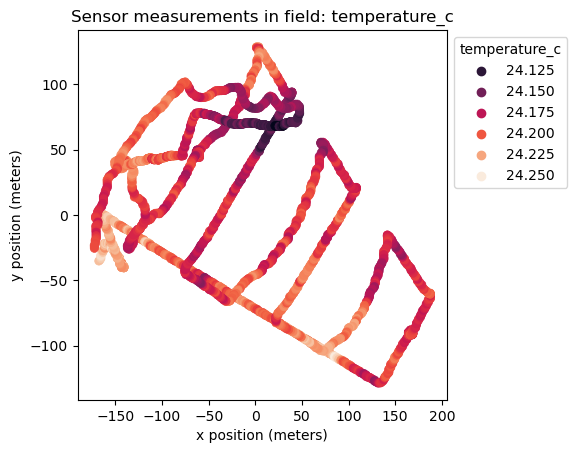

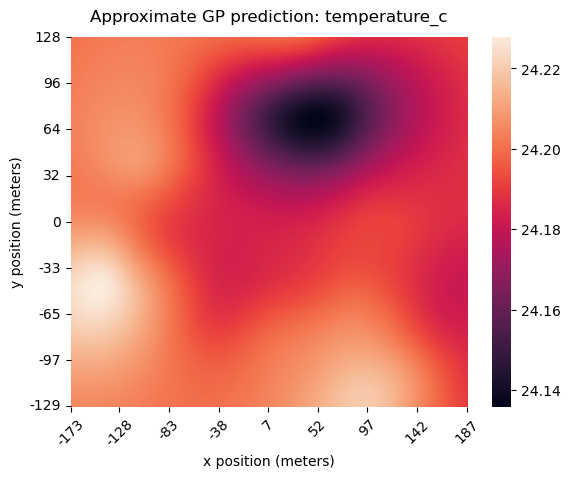

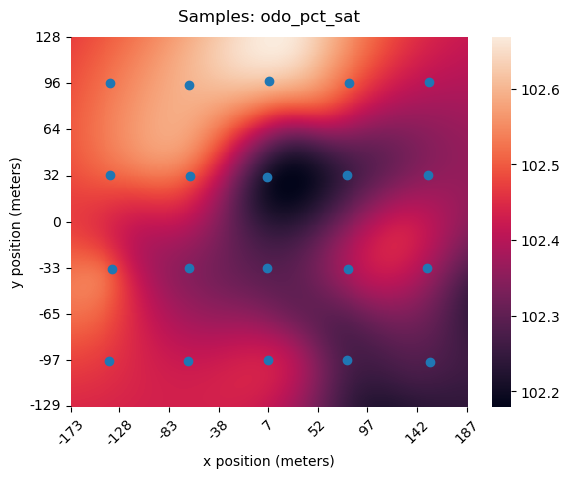

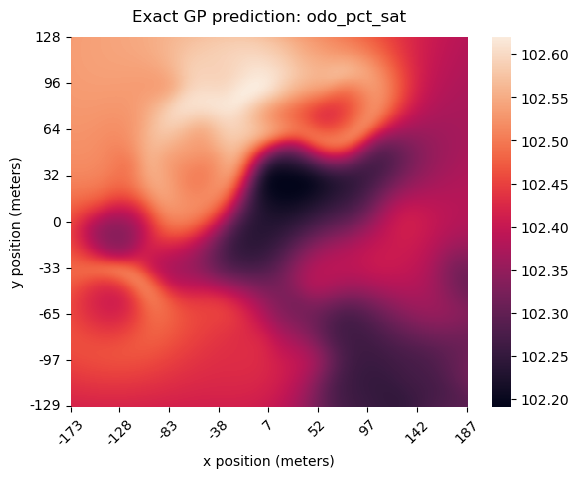

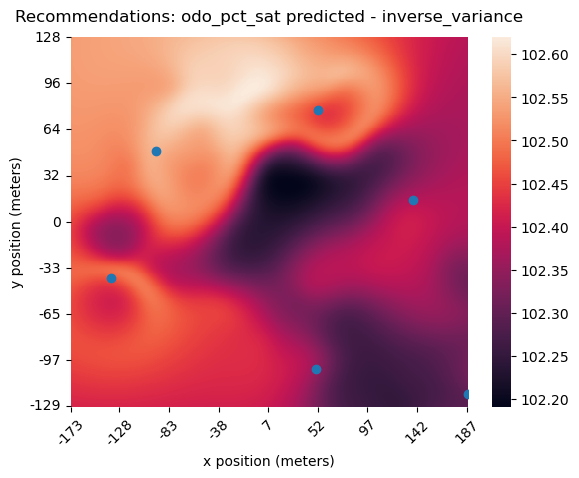

In [14]:
ls_sampler = PredictiveSampler(measurements=ls_X)

demonstrate_with_data(
    ls_sampler,
    sensor_field_to_plot='temperature_c',
    sampling_field='odo_pct_sat_pred',
    n_samples=20,
    sample_noise_ratio=0.1,
    n_to_recommend=6,
    fitness_function=PredictiveSampler.inverse_variance_fitness,
    override_variance=True
)

In [15]:
# cross-validation results are slightly different than the figures
# differences are not significant and do not affect the analysis
# possibly caused by random seed mismatches, unsure exactly why
ls_results_df = measurements_cross_validate(ls_X)
ls_results_df.info()

preliminary - predicting fields from measurements...
predicting field 'temperature_c'
selected 40 inducing points with threshold 0.5
selected 75 inducing points with threshold 0.6
maximum number of inducing points (300) exceeded with threshold 0.700
selected 135 inducing points with threshold 0.6499999999999999
selected 226 inducing points with threshold 0.6749999999999999
maximum number of inducing points (300) exceeded with threshold 0.700
maximum number of inducing points (300) exceeded with threshold 0.688
selected 226 inducing points with threshold 0.675
selected 295 inducing points with threshold 0.68125
1/200: loss = 1.956337
20/200: loss = 1.094596
40/200: loss = 1.006329
60/200: loss = 0.993527
80/200: loss = 0.990869
100/200: loss = 0.990231
120/200: loss = 0.990052
140/200: loss = 0.989981
160/200: loss = 0.989944
180/200: loss = 0.989922
200/200: loss = 0.989902
Parameter variational_strategy.inducing_points: torch.Size([295, 2])
Parameter variational_strategy._variational_

/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.2, 'Lake Sunapee: relative error vs. number of feature fields')

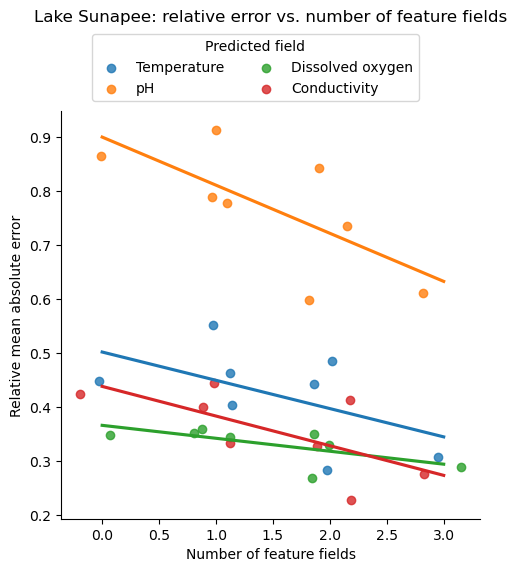

In [16]:
ax = sns.lmplot(
    ls_results_df,
    x='n_feature_fields',
    y='relative_mae',
    hue='target_field',
    col='n_samples',
    row='sample_noise_ratio',
    x_jitter=0.2,
    sharey=False,
    ci=None,
    facet_kws={'legend_out': False}
)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.18, 1.1), ncol=2)
ax._legend.set_title('Predicted field')
labels = ['Temperature', 'pH', 'Dissolved oxygen', 'Conductivity']
for text, label in zip(ax._legend.texts, labels):
    text.set_text(label)

plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Lake Sunapee: relative error vs. number of feature fields', y=1.2)

### Lac Hertel dataset

In [17]:
lh_df = pd.read_csv('water_quality_dataset/water_quality_measurments.csv')
lh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   %time                4514 non-null   float64
 1   field.header.seq     4514 non-null   int64  
 2   field.header.stamp   4514 non-null   float64
 3   field.stamp_sonde    4514 non-null   float64
 4   field.temp_c         4514 non-null   float64
 5   field.spcond_u       4514 non-null   float64
 6   field.sal            4514 non-null   float64
 7   field.ph             4514 non-null   float64
 8   field.orp            4514 non-null   float64
 9   field.depth_m        4514 non-null   float64
 10  field.turbidity_ntu  4514 non-null   float64
 11  field.turbidity_fnu  4514 non-null   float64
 12  field.odo_percsat    4514 non-null   float64
 13  field.odo_m          4514 non-null   float64
 14  field.latitude       4514 non-null   float64
 15  field.longitude      4514 non-null   f

In [18]:
lh_X = lh_df[[
    'field.latitude',
    'field.longitude',
    'field.temp_c',
    'field.ph',
    'field.odo_percsat',
    'field.spcond_u',
    'field.orp',
    'field.turbidity_ntu'
]].astype(np.float32).rename(columns={
    'field.latitude': 'latitude',
    'field.longitude': 'longitude',
    'field.temp_c': 'temp_c',
    'field.ph': 'ph',
    'field.odo_percsat': 'odo_percsat',
    'field.spcond_u': 'spcond_u',
    'field.orp': 'orp',
    'field.turbidity_ntu': 'turbidity_ntu'
})

lh_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       4514 non-null   float32
 1   longitude      4514 non-null   float32
 2   temp_c         4514 non-null   float32
 3   ph             4514 non-null   float32
 4   odo_percsat    4514 non-null   float32
 5   spcond_u       4514 non-null   float32
 6   orp            4514 non-null   float32
 7   turbidity_ntu  4514 non-null   float32
dtypes: float32(8)
memory usage: 141.2 KB


In [19]:
lh_converter = CoordinateConverter()
lh_X = lh_converter.latlon_to_xy(lh_X)
lh_X.sample(5)

,latitude,longitude,temp_c,ph,odo_percsat,spcond_u,orp,turbidity_ntu,x_pos,y_pos
855,45.543907,-73.153030,24.724001,10.24,109.779999,75.199997,132.419998,0.80,-80.754349,-61.620358
896,45.543636,-73.152924,24.711000,10.23,109.339996,75.129997,133.410004,0.75,-72.614365,-91.469398
2971,45.545189,-73.151451,24.872000,10.19,109.900002,75.160004,145.320007,0.74,38.592514,83.707756
1580,45.545071,-73.152504,24.764999,10.23,110.139999,75.150002,137.770004,0.76,-43.226513,68.896271
2965,45.545151,-73.151451,24.877001,10.19,109.870003,75.059998,145.350006,0.73,38.687679,79.527542


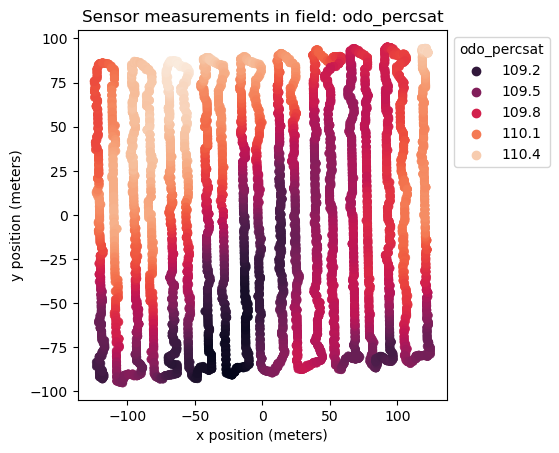

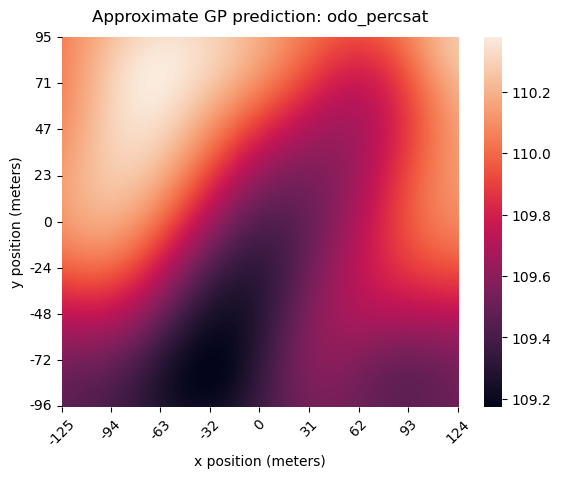

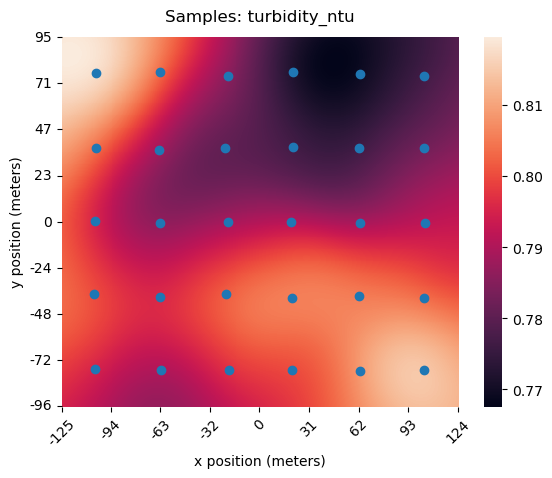

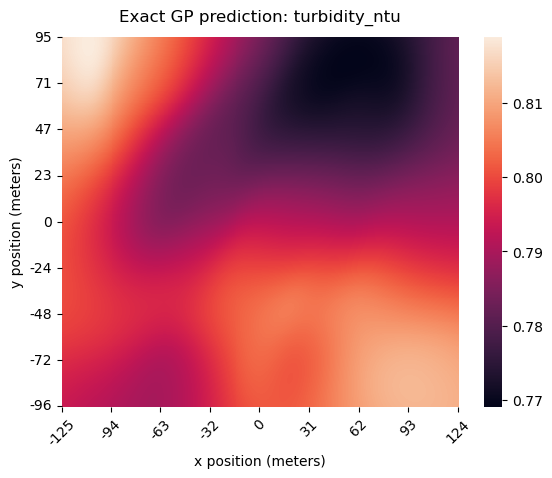

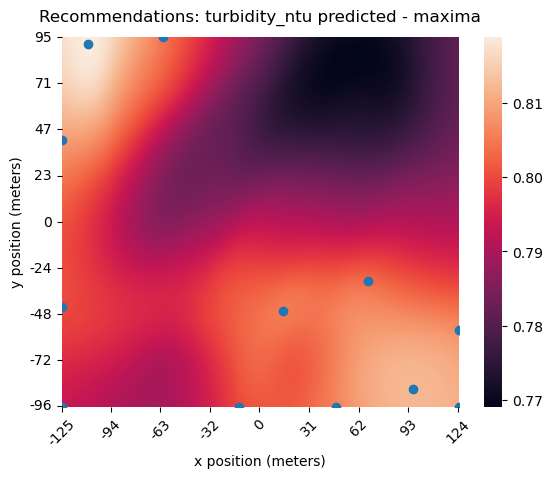

In [20]:
lh_sampler = PredictiveSampler(measurements=lh_X)

demonstrate_with_data(
    lh_sampler,
    sensor_field_to_plot='odo_percsat',
    sampling_field='turbidity_ntu_pred',
    n_samples=30,
    sample_noise_ratio=0.1,
    n_to_recommend=12,
    fitness_function=PredictiveSampler.maxima_fitness
)

In [21]:
lh_results_df = measurements_cross_validate(lh_X)
lh_results_df.info()

preliminary - predicting fields from measurements...
predicting field 'temp_c'
selected 53 inducing points with threshold 0.5
selected 112 inducing points with threshold 0.6
maximum number of inducing points (300) exceeded with threshold 0.700
maximum number of inducing points (300) exceeded with threshold 0.650
selected 112 inducing points with threshold 0.5999999999999999
selected 150 inducing points with threshold 0.6249999999999999
maximum number of inducing points (300) exceeded with threshold 0.650
selected 203 inducing points with threshold 0.6375
selected 257 inducing points with threshold 0.6437499999999999
1/200: loss = 1.956488
20/200: loss = 0.973074
40/200: loss = 0.890854
60/200: loss = 0.870123
80/200: loss = 0.860978
100/200: loss = 0.855693
120/200: loss = 0.852139
140/200: loss = 0.849420
160/200: loss = 0.847468
180/200: loss = 0.845743
200/200: loss = 0.844524
Parameter variational_strategy.inducing_points: torch.Size([257, 2])
Parameter variational_strategy._variat

/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.2, 'Lac Hertel: relative error vs. number of feature fields')

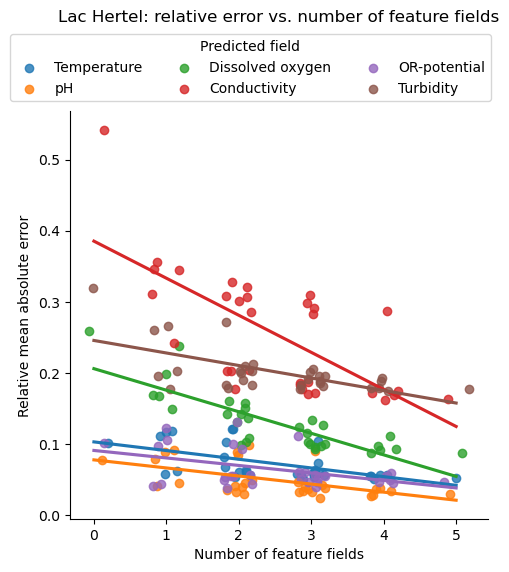

In [22]:
ax = sns.lmplot(
    lh_results_df,
    x='n_feature_fields',
    y='relative_mae',
    hue='target_field',
    col='n_samples',
    row='sample_noise_ratio',
    x_jitter=0.2,
    sharey=False,
    ci=None,
    facet_kws={'legend_out': False}
)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0, 1.1), ncol=3)
ax._legend.set_title('Predicted field')
labels = ['Temperature', 'pH', 'Dissolved oxygen', 'Conductivity', 'OR-potential', 'Turbidity']
for text, label in zip(ax._legend.texts, labels):
    text.set_text(label)

plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Lac Hertel: relative error vs. number of feature fields', y=1.2)


### Google Earth Engine

In [26]:
# set to True to get new data from Earth Engine, which requires authentication and a cloud project
# otherwise, read saved results from file
use_earth_engine = False

In [25]:
# re-authentication is required periodically
# this code requires the creation of a Google Earth Engine Cloud project
# see https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup

if use_earth_engine:
    ee.Authenticate()


Successfully saved authorization token.


In [27]:
if use_earth_engine:
    gcp_project_name = 'ee-znathan-thesis'
    ee.Initialize(project=gcp_project_name)

In [28]:
if use_earth_engine:

    # define the area of interest as a GeoJSON (1 squared degree in southwestern Ontario)
    area_of_interest = ee.Geometry.Polygon([
        [
            [-80, 43],
            [-81, 43],
            [-81, 44],
            [-80, 44],
            [-80, 43]
        ]
    ])

    datasets = {
        'COPERNICUS/S5P/NRTI/L3_AER_AI': ['absorbing_aerosol_index'],
        'COPERNICUS/S5P/NRTI/L3_CO': ['CO_column_number_density', 'H2O_column_number_density'],
        'COPERNICUS/S5P/NRTI/L3_HCHO': ['tropospheric_HCHO_column_number_density'],
        'COPERNICUS/S5P/NRTI/L3_NO2': ['NO2_column_number_density'],
        'COPERNICUS/S5P/NRTI/L3_O3': ['O3_column_number_density'],
        'COPERNICUS/S5P/NRTI/L3_SO2': ['SO2_column_number_density']
    }

    # date range, note that some dates will not have data for the area of interest
    start_date = ee.Date('2022-07-01')
    end_date = ee.Date('2022-08-01')

    # fetch satellite data according to the specified parameters
    satellite_datasets = [get_ee_dataset(
        dataset,
        bands,
        area_of_interest,
        start_date,
        end_date
    ) for dataset, bands in datasets.items()]

    # recursively merge the satellite datasets into a single dataframe
    ee_df = reduce(
        lambda left, right: pd.merge(left, right, on=['latitude', 'longitude'], how='outer'),
        satellite_datasets
    )
    ee_df.to_csv('earth_engine_dataset.csv')

else:
    ee_df = pd.read_csv('earth_engine_dataset.csv')

fetching bands ['absorbing_aerosol_index'] from dataset COPERNICUS/S5P/NRTI/L3_AER_AI...
fetching bands ['CO_column_number_density', 'H2O_column_number_density'] from dataset COPERNICUS/S5P/NRTI/L3_CO...
fetching bands ['tropospheric_HCHO_column_number_density'] from dataset COPERNICUS/S5P/NRTI/L3_HCHO...
fetching bands ['NO2_column_number_density'] from dataset COPERNICUS/S5P/NRTI/L3_NO2...
fetching bands ['O3_column_number_density'] from dataset COPERNICUS/S5P/NRTI/L3_O3...
fetching bands ['SO2_column_number_density'] from dataset COPERNICUS/S5P/NRTI/L3_SO2...


In [29]:
ee_X = ee_df.astype(np.float32).rename(columns={
    'CO_column_number_density': 'CO_cnd',
    'H2O_column_number_density': 'H2O_cnd',
    'tropospheric_HCHO_column_number_density': 'HCHO_cnd',
    'NO2_column_number_density': 'NO2_cnd',
    'O3_column_number_density': 'O3_cnd',
    'SO2_column_number_density': 'SO2_cnd',
})

In [30]:
ee_converter = CoordinateConverter()
ee_X = ee_converter.latlon_to_xy(ee_X)
ee_X.sample(5)

,latitude,longitude,absorbing_aerosol_index,CO_cnd,H2O_cnd,HCHO_cnd,NO2_cnd,O3_cnd,SO2_cnd,x_pos,y_pos
8375,43.837914,-80.247398,-0.845971,NaN,NaN,0.000153,0.000084,0.145241,-0.000072,19817.666016,37141.097656
1985,43.197914,-80.147400,-0.783458,NaN,NaN,0.000009,0.000095,0.144046,-0.000079,28585.871094,-33858.851562
18477,43.849655,-80.224121,NaN,0.029036,1284.135376,NaN,NaN,NaN,NaN,21676.748047,38462.218750
18516,43.859657,-80.834122,NaN,0.028895,1405.211182,NaN,NaN,NaN,NaN,-27354.328125,39293.855469
9660,43.967915,-80.397400,-0.705844,NaN,NaN,0.000091,0.000081,0.145136,0.000109,7654.242188,51480.625000


In [31]:
ee_X = discard_outliers(ee_X, limit=3.0)

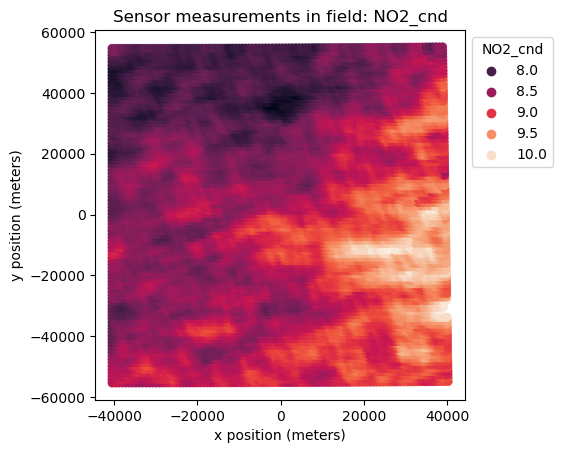

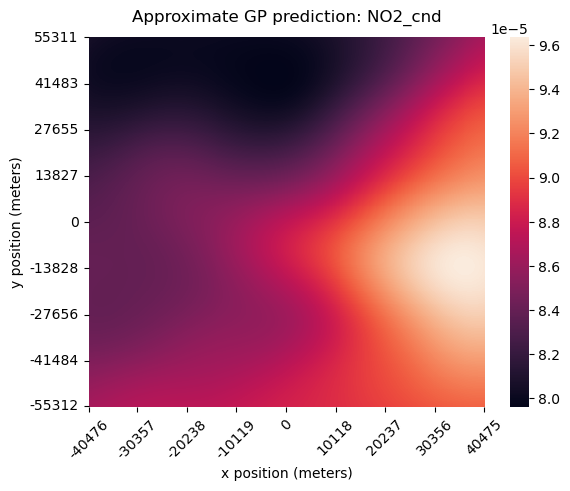

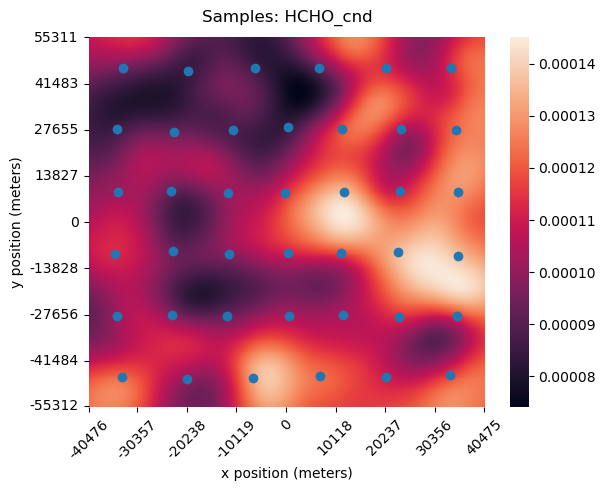

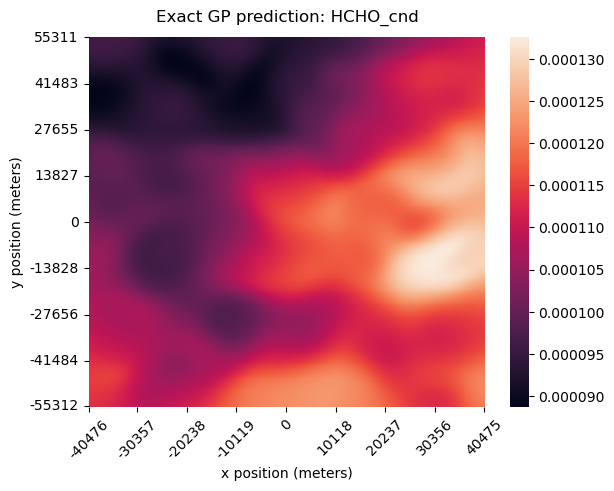

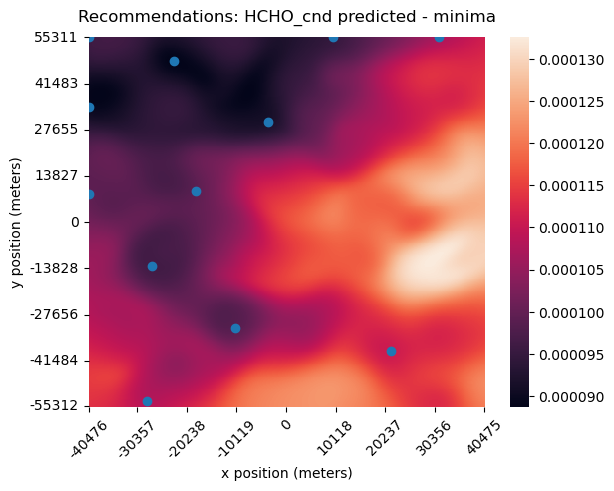

In [32]:
ee_sampler = PredictiveSampler(measurements=ee_X)

demonstrate_with_data(
    ee_sampler,
    sensor_field_to_plot='NO2_cnd',
    sampling_field='HCHO_cnd_pred',
    n_inducing_point_bounds=(450, 500),
    n_samples=40,
    sample_noise_ratio=0.1,
    n_to_recommend=12,
    fitness_function=PredictiveSampler.minima_fitness
)

In [33]:
ee_results_df = measurements_cross_validate(ee_X)
ee_results_df.info()

preliminary - predicting fields from measurements...
predicting field 'absorbing_aerosol_index'
selected 71 inducing points with threshold 0.5
selected 175 inducing points with threshold 0.6
maximum number of inducing points (300) exceeded with threshold 0.700
maximum number of inducing points (300) exceeded with threshold 0.650
selected 175 inducing points with threshold 0.5999999999999999
selected 246 inducing points with threshold 0.6249999999999999
maximum number of inducing points (300) exceeded with threshold 0.650
maximum number of inducing points (300) exceeded with threshold 0.637
selected 246 inducing points with threshold 0.625
maximum number of inducing points (300) exceeded with threshold 0.631
selected 271 inducing points with threshold 0.6281249999999999
1/200: loss = 1.956867
20/200: loss = 1.299639
40/200: loss = 1.233277
60/200: loss = 1.221684
80/200: loss = 1.217992
100/200: loss = 1.216970
120/200: loss = 1.216605
140/200: loss = 1.216389
160/200: loss = 1.216240
1

/opt/homebrew/Caskroom/miniforge/base/envs/boost/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.24, 'Sentinel-5P: relative error vs. number of feature fields')

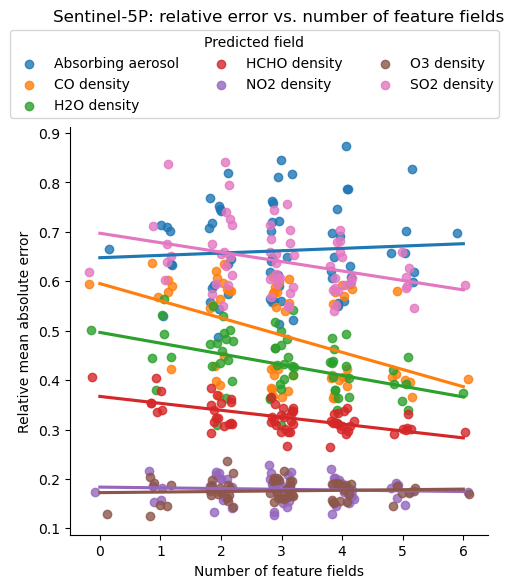

In [34]:
ax = sns.lmplot(
    ee_results_df,
    x='n_feature_fields',
    y='relative_mae',
    hue='target_field',
    col='n_samples',
    row='sample_noise_ratio',
    x_jitter=0.2,
    sharey=False,
    ci=None,
    facet_kws={'legend_out': False}
)

sns.move_legend(ax, 'upper left', bbox_to_anchor=(0, 1.14), ncol=3)
ax._legend.set_title('Predicted field')
labels = ['Absorbing aerosol', 'CO density', 'H2O density', 'HCHO density', 'NO2 density', 'O3 density', 'SO2 density']
for text, label in zip(ax._legend.texts, labels):
    text.set_text(label)
    
plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Sentinel-5P: relative error vs. number of feature fields', y=1.24)


## Testing: generated datasets

In [35]:
# change to True for re-running the tests, otherwise load past results from file
run_tests = False

In [36]:
def random_cross_validate_approximate(
    n_fields: int = 20,
    len_scales: List[float] = [0.5, 1.0],
    n_turns_s: List[int] = [5, 9],
    sensor_noise_ratios: List[float] = [0.05, 0.1],
    n_inducing_point_bounds_s: List[Tuple[int, int]] = [(150, 200), (250, 300)],
    random_seed: int = None
) -> pd.DataFrame:

    if random_seed is not None:
        np.random.seed(random_seed)

    results = {
        'result_name': [],
        'rmse': [],
        'mae': [],
        'relative_rmse': [],
        'relative_mae': [],
        'len_scale': [],
        'n_turns': [],
        'n_measurements': [],
        'sensor_noise_ratio': [],
        'n_inducing_points': []
    }

    i = 0
    i_total = n_fields * len(len_scales) * len(n_inducing_point_bounds_s) * len(n_turns_s) * len(sensor_noise_ratios)

    for len_scale in len_scales:

        print(f'generating {n_fields} fields with len_scale={len_scale}...')

        source = PredictiveSampler()
        source.generate_random_fields(
            n_fields=n_fields,
            len_scale=len_scale,
            minmax=True
        )

        field_stats = {
            field: {'mad': source.grid[field].mad(), 'sd': source.grid[field].std()}
            for field in source.generated_fields
        }

        for n_turns in n_turns_s:

            for sensor_noise_ratio in sensor_noise_ratios:

                print(f'simulating measurements with n_turns={n_turns} and sensor_noise_ratio={sensor_noise_ratio}')

                measurements = source.simulate_lawnmower_sensors(
                    n_turns=n_turns,
                    spacing=5,
                    sensor_noise_ratio=sensor_noise_ratio,
                    spatial_noise_ratio=sensor_noise_ratio
                )

                n_measurements = len(measurements)
                source.measurements = measurements

                for n_inducing_point_bounds in n_inducing_point_bounds_s:

                    print(f'predicting {n_fields} fields with n_inducing_point_bounds={n_inducing_point_bounds}')
                    source.cached_inducing_points = None

                    for field_name in source.measurements_fields():

                        result_name = f'{len_scale}_{field_name}-{n_turns}_{sensor_noise_ratio}-{n_inducing_point_bounds[1]}'

                        i += 1
                        print(f'running prediction {i} of {i_total}...')


                        try:
                            source.predict_field(
                                source.measurements,
                                field_name,
                                ['x_pos', 'y_pos'],
                                result_name=result_name,
                                n_iterations=100,
                                n_inducing_point_bounds=n_inducing_point_bounds,
                                no_print=False
                            )

                        except ValueError:
                            print('skipping error...')
                            continue

                        rmse = source.fields_root_mean_squared_error(field_name, result_name)
                        mae = source.fields_mean_absolute_error(field_name, result_name)
                        actual_n_inducing_points = source.last_n_inducing_points

                        results['result_name'].append(result_name)
                        results['rmse'].append(rmse)
                        results['mae'].append(mae)
                        results['relative_rmse'].append(rmse / field_stats[field_name]['sd'])
                        results['relative_mae'].append(mae / field_stats[field_name]['mad'])
                        results['len_scale'].append(len_scale)
                        results['n_turns'].append(n_turns)
                        results['n_measurements'].append(n_measurements)
                        results['sensor_noise_ratio'].append(sensor_noise_ratio)
                        results['n_inducing_points'].append(actual_n_inducing_points)

    return pd.DataFrame(results)

In [37]:
if run_tests:
    approximate_results_df = random_cross_validate_approximate(
        n_fields=5,
        len_scales=[0.3, 0.5, 0.75, 1.0, 1.3, 1.7],
        n_turns_s=[3, 4, 5, 7, 9, 12, 15],
        sensor_noise_ratios=[0.1],
        n_inducing_point_bounds_s=[(11, 20), (21, 40), (41, 70), (71, 110), (111, 160), (161, 220), (221, 290), (291, 370)],
        random_seed=1
    )
    approximate_results_df.to_csv('approximate_gp_results_new.csv')
    
else:
    approximate_results_df = pd.read_csv('approximate_gp_results.csv')

approximate_results_df.head()

,Unnamed: 0,result_name,rmse,mae,relative_rmse,relative_mae,len_scale,n_turns,n_measurements,sensor_noise_ratio,n_inducing_points,Inducing points,Number of inducing points (binned)
0,0,0.3_random_field_0-3_0.1-20,0.152134,0.121823,0.907052,0.915043,0.3,3,400,0.1,19,11 - 40,11 - 40
1,1,0.3_random_field_1-3_0.1-20,0.171614,0.135507,0.997989,0.978932,0.3,3,400,0.1,19,11 - 40,11 - 40
2,2,0.3_random_field_2-3_0.1-20,0.134588,0.109117,0.952060,0.955140,0.3,3,400,0.1,19,11 - 40,11 - 40
3,3,0.3_random_field_3-3_0.1-20,0.176760,0.141986,0.970048,0.955646,0.3,3,400,0.1,19,11 - 40,11 - 40
4,4,0.3_random_field_4-3_0.1-20,0.142868,0.113819,0.932342,0.929061,0.3,3,400,0.1,19,11 - 40,11 - 40


In [38]:
grouped_results_df = approximate_results_df.groupby(
    ['len_scale', 'n_turns', 'n_measurements', 'sensor_noise_ratio', 'n_inducing_points']
).aggregate({
    'rmse': 'mean',
    'mae': 'mean',
    'relative_rmse': 'mean',
    'relative_mae': 'mean'
}).reset_index()

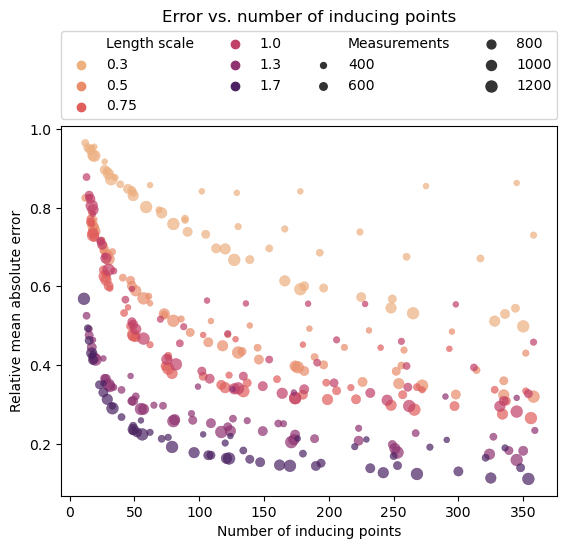

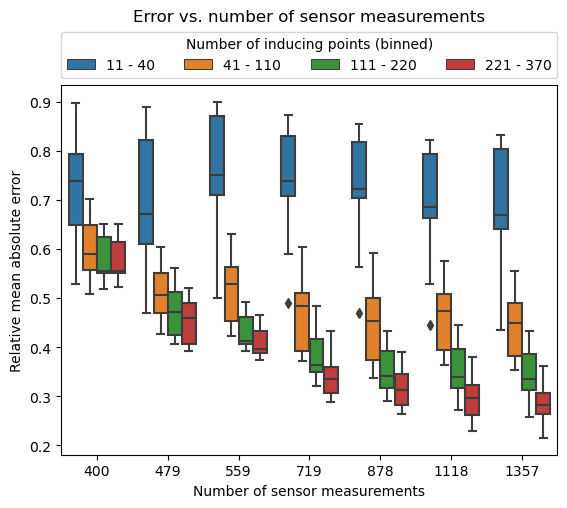

In [39]:
grouped_results_df = approximate_results_df.groupby(
    ['len_scale', 'n_turns', 'n_measurements', 'sensor_noise_ratio', 'n_inducing_points']
).aggregate({
    'rmse': 'median',
    'mae': 'median',
    'relative_rmse': 'median',
    'relative_mae': 'median'
}).reset_index()

ax = sns.scatterplot(
    grouped_results_df.rename(columns={
        'len_scale': 'Length scale',
        'n_measurements': 'Measurements'
    }),
    x='n_inducing_points',
    y='relative_mae',
    hue='Length scale',
    size='Measurements',
    alpha=0.7,
    palette='flare',
    edgecolor=None
)
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1.02, 1, 0), ncols=4, mode='expand', borderaxespad=0.0)
plt.xlabel('Number of inducing points')
plt.ylabel('Relative mean absolute error')
plt.title('Error vs. number of inducing points', y=1.26)
plt.show()


approximate_results_df['Number of inducing points (binned)'] = sum(
    approximate_results_df['n_inducing_points'] > i for i in (40, 110, 220)
).map({0: '11 - 40', 1: '41 - 110', 2: '111 - 220', 3: '221 - 370'})

ax = sns.boxplot(
    approximate_results_df[approximate_results_df['len_scale'] == 1.0],
    x='n_measurements',
    y='relative_mae',
    hue='Number of inducing points (binned)'
)
sns.move_legend(ax, 'lower left', bbox_to_anchor=(0, 1.02, 1, 0), ncols=4, mode='expand', borderaxespad=0.0)
plt.xlabel('Number of sensor measurements')
plt.ylabel('Relative mean absolute error')
plt.title('Error vs. number of sensor measurements', y=1.15)
plt.show()

In [40]:
def new_results():
    return {
        'result_name': [],
        'rmse': [],
        'mae': [],
        'relative_rmse': [],
        'relative_mae': [],
        'n_feature_fields': [],
        'feature_fields_ids': [],
        'len_scale': [],
        'similarity_factor': [],
        'n_samples': [],
        'sample_noise_ratio': []
    }


def random_cross_validate_exact(
    n_fields: int = 10,
    len_scales: List[float] = [1.0],
    similarity_factors: List[float] = [0.0, 0.5],
    n_turns: int = 5,
    sensor_noise_ratio: float = 0.1,
    n_inducing_point_bounds: Tuple[int, int] = (250, 300),
    n_samples_s: List[int] = [16, 36],
    sample_noise_ratios: List[float] = [0.0, 0.5],
    n_combinations_limit: int = 5,
    random_seed: int = None
) -> pd.DataFrame:

    if random_seed is not None:
        np.random.seed(random_seed)
    rng = np.random.default_rng()

    results = new_results()

    start_time = str(time.time())
    results_filename = f'test_results/cross_validation-{start_time}'
    using_file = False
    file_chunksize = 100

    i = 0
    n_combinations_per_field = sum(min(math.comb(n_fields - 1, k), n_combinations_limit) for k in range(n_fields))
    i_total = (n_combinations_per_field * n_fields * len(n_samples_s) * len(sample_noise_ratios) + n_fields) * len(len_scales) * len(similarity_factors)
    print(f'total number of tests will be {i_total}')
    
    for len_scale in len_scales:
        for similarity_factor in similarity_factors:

            print(f'generating {n_fields} fields with len_scale={len_scale} and similarity_factor={similarity_factor}...')

            source = PredictiveSampler()
            source.generate_random_fields(
                n_fields=n_fields,
                len_scale=len_scale,
                common_basis_factor=similarity_factor,
                minmax=True
            )

            print(f'simulating measurements with n_turns={n_turns} and sensor_noise_ratio={sensor_noise_ratio}')

            measurements = source.simulate_lawnmower_sensors(
                n_turns=n_turns,
                spacing=5,
                sensor_noise_ratio=sensor_noise_ratio
            )
            source.measurements = measurements

            print(f'predicting {n_fields} fields with n_inducing_point_bounds={n_inducing_point_bounds}')
            source.cached_inducing_points = None

            for field_name in source.measurements_fields():

                result_name = f'{len_scale}_{similarity_factor}_{field_name}_pred'

                i += 1
                print(f'running prediction {i} of {i_total}...')

                try:
                    source.predict_field(
                        source.measurements,
                        field_name,
                        ['x_pos', 'y_pos'],
                        result_name=result_name,
                        n_iterations=50,
                        n_inducing_point_bounds=n_inducing_point_bounds,
                        no_print=False
                    )

                except ValueError:
                    print('skipping error...')
                    continue

            predicted_fields = source.predicted_fields.copy()

            for n_samples in n_samples_s:
                for sample_noise_ratio in sample_noise_ratios:

                    if len(results['result_name']) >= file_chunksize:
                        results_df = pd.DataFrame(results)
                        results_df.to_csv(
                            results_filename,
                            header=(not using_file),
                            mode=('w' if not using_file else 'a')
                        )
                        using_file = True
                        results_df = None
                        results = new_results()

                    print(f'simulating samples with n_samples={n_samples} and sample_noise_ratio={sample_noise_ratio}...')

                    for sampling_field in source.generated_fields:

                        sampling_field_mad = source.grid[sampling_field].mad()
                        sampling_field_sd = source.grid[sampling_field].std()

                        print(f'simulating samples for target {sampling_field}...')

                        feature_fields = [field for field in predicted_fields if not field.endswith(f'{sampling_field}_pred')]
                        assert len(feature_fields) == n_fields - 1

                        samples_name = f'{len_scale}_{similarity_factor}_{sampling_field}-{n_samples}_{sample_noise_ratio}'

                        samples = source.simulate_lattice_samples(
                            field_name=sampling_field,
                            result_name=samples_name,
                            n_samples=n_samples,
                            sample_noise_ratio=sample_noise_ratio,
                            spatial_noise_ratio=sample_noise_ratio,
                            all_columns=True
                        )

                        for k in range(n_fields):

                            print(f'predicting {sampling_field} with {k} feature fields...')

                            n_combinations = math.comb(n_fields - 1, k)
                            feature_subsets = list(combinations(feature_fields, k))
                            if n_combinations > n_combinations_limit:
                                print(f'{n_combinations} is greater than the limit {n_combinations_limit}, choosing some combinations randomly...')
                                feature_subsets = rng.choice(feature_subsets, n_combinations_limit, replace=False, shuffle=False)

                            for j, feature_subset in enumerate(feature_subsets):

                                i += 1
                                print(f'running prediction {i} of {i_total}...')

                                result_name = f'{samples_name}-{k}_{j}'
                                source.predict_field(
                                    samples,
                                    target=samples_name,
                                    features=['x_pos', 'y_pos'] + list(feature_subset),
                                    result_name=result_name,
                                    is_sampling=True,
                                    n_iterations=100
                                )

                                rmse = source.fields_root_mean_squared_error(sampling_field, result_name)
                                mae = source.fields_mean_absolute_error(sampling_field, result_name)
                                source.drop_field(result_name)

                                results['result_name'].append(result_name)
                                results['rmse'].append(rmse)
                                results['mae'].append(mae)
                                results['relative_rmse'].append(rmse / sampling_field_sd)
                                results['relative_mae'].append(mae / sampling_field_mad)
                                results['n_feature_fields'].append(k)
                                results['feature_fields_ids'].append(str(feature_subset))#','.join(f.split('_')[-2] for f in feature_subset))
                                results['len_scale'].append(len_scale)
                                results['similarity_factor'].append(similarity_factor)
                                results['n_samples'].append(n_samples)
                                results['sample_noise_ratio'].append(sample_noise_ratio)

    results_df = pd.DataFrame(results)
    results_df.to_csv(
        results_filename,
        header=(not using_file),
        mode=('w' if not using_file else 'a')
    )

    return pd.read_csv(results_filename)

In [41]:
if run_tests:
    exact_results_df = random_cross_validate_exact(
        n_fields=10,
        similarity_factors=[0.0, 0.3, 0.6],
        n_samples_s=[15, 30, 45],
        sample_noise_ratios=[0.0, 0.3, 0.6],
        n_combinations_limit=3,
        random_seed=9
    )
    exact_results_df.to_csv('exact_gp_results_new.csv')
    
else:
    exact_results_df = pd.read_csv('exact_gp_results.csv')

exact_results_df.head()

,Unnamed: 0,result_name,rmse,mae,relative_rmse,relative_mae,n_feature_fields,feature_fields_ids,len_scale,similarity_factor,n_samples,sample_noise_ratio
0,0,1.0_0.0_random_field_0-15_0.0-0_0,0.080425,0.065177,0.367893,0.382168,0,(),1.0,0.0,15,0.0
1,1,1.0_0.0_random_field_0-15_0.0-1_0,0.081694,0.063443,0.373698,0.372001,1,['1.0_0.0_random_field_1_pred'],1.0,0.0,15,0.0
2,2,1.0_0.0_random_field_0-15_0.0-1_1,0.098189,0.077227,0.449153,0.452824,1,['1.0_0.0_random_field_3_pred'],1.0,0.0,15,0.0
3,3,1.0_0.0_random_field_0-15_0.0-1_2,0.107914,0.083048,0.493639,0.486956,1,['1.0_0.0_random_field_9_pred'],1.0,0.0,15,0.0
4,4,1.0_0.0_random_field_0-15_0.0-2_0,0.106589,0.082022,0.487576,0.480941,2,['1.0_0.0_random_field_1_pred' '1.0_0.0_random...,1.0,0.0,15,0.0


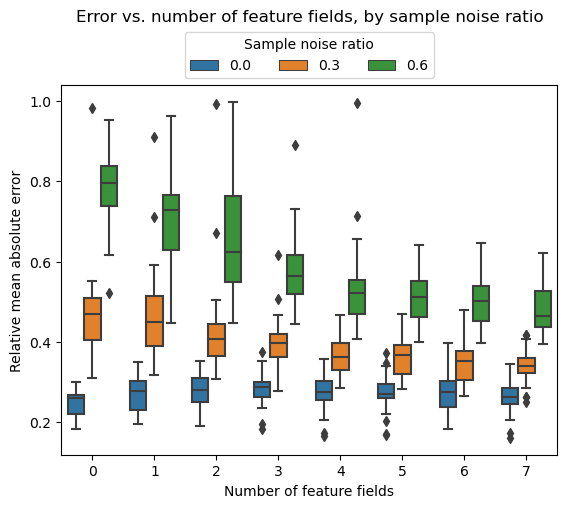

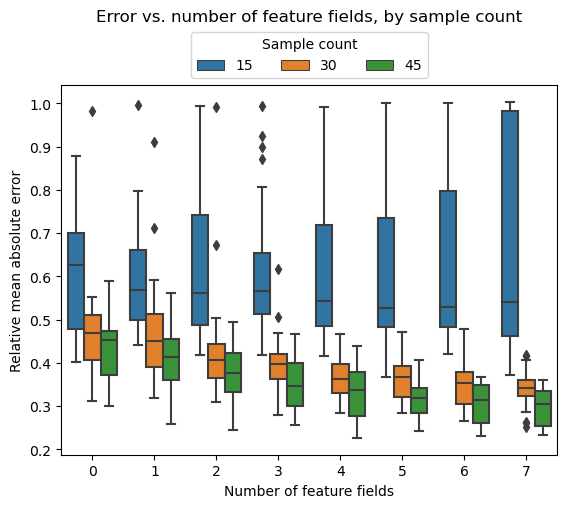

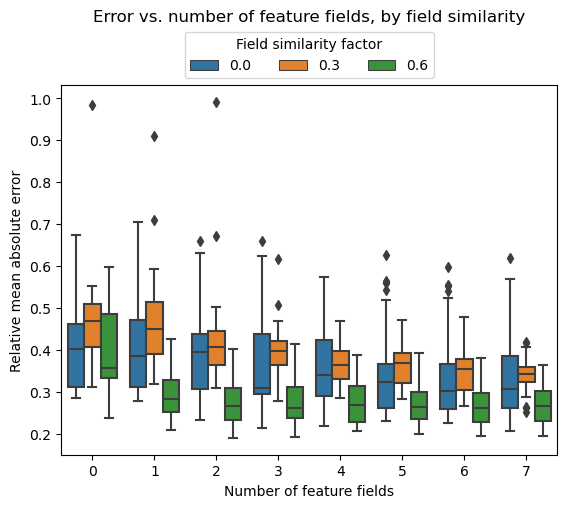

In [42]:
exact_results_df['target_field_id'] = exact_results_df['result_name'].str.split('-').str[0].str.split('_').str[-1]

display_df = exact_results_df[exact_results_df['n_feature_fields'] < 8].rename(columns={
        'sample_noise_ratio': 'Sample noise ratio',
        'n_samples': 'Sample count',
        'similarity_factor': 'Field similarity factor'
})

ax = sns.boxplot(
    display_df[
        (display_df['Field similarity factor'] == 0.3) &
        (display_df['Sample count'] == 30)
    ],
    x='n_feature_fields',
    y='relative_mae',
    # row='similarity_factor',
    # col='n_samples',
    hue='Sample noise ratio'
)
sns.move_legend(ax, 'lower center', bbox_to_anchor=(0.5, 1), ncols=3)
plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Error vs. number of feature fields, by sample noise ratio', y=1.15)
plt.show()


ax = sns.boxplot(
    display_df[
        (display_df['Field similarity factor'] == 0.3) &
        (display_df['Sample noise ratio'] == 0.3)
    ],
    x='n_feature_fields',
    y='relative_mae',
    # row='similarity_factor',
    # col='sample_noise_ratio',
    hue='Sample count'
)
sns.move_legend(ax, 'lower center', bbox_to_anchor=(0.5, 1), ncols=3)
plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Error vs. number of feature fields, by sample count', y=1.15)
plt.show()


ax = sns.boxplot(
    display_df[
        (display_df['Sample noise ratio'] == 0.3) &
        (display_df['Sample count'] == 30)
    ],
    x='n_feature_fields',
    y='relative_mae',
    # row='n_samples',
    # col='sample_noise_ratio',
    hue='Field similarity factor'
)
sns.move_legend(ax, 'lower center', bbox_to_anchor=(0.5, 1), ncols=3)
plt.xlabel('Number of feature fields')
plt.ylabel('Relative mean absolute error')
plt.title('Error vs. number of feature fields, by field similarity', y=1.15)
plt.show()